<a href="https://colab.research.google.com/github/jddfrance/ifoodextract/blob/main/ifood_extract_0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gmaps

     |████████████████████████████████| 1.1 MB 26.1 MB/s 
  Created wheel for gmaps: filename=gmaps-0.9.0-py2.py3-none-any.whl size=2076111 sha256=7d81e8164ca461839129e53564de822933d2dc66e1cf86dbf1594435f00a6771
  Stored in directory: /root/.cache/pip/wheels/3d/1c/cb/c46f4199210e632b28d78d05a00bfdccbf6dfcd3f5b051d6bf
Successfully built gmaps


In [2]:
import requests
from bs4 import BeautifulSoup 
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Map imports
from bokeh.io import output_notebook
from bokeh.io import show
from bokeh.plotting import gmap
from bokeh.models import GMapOptions
from bokeh.models import WheelZoomTool
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool
from bokeh.transform import linear_cmap
from bokeh.palettes import Turbo256 as palette
from bokeh.models import ColorBar


In [3]:
s = requests.Session() #maintain the same session throught the whole execution
def get_web(url):
  headers = {'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Mobile Safari/537.36'}
  texto = s.get(url, headers = headers).text
  return texto

In [4]:
def get_rest(lastitude, longitude, pages = None):
  if pages == None: #get all possible pages
    url = f"https://marketplace.ifood.com.br/v1/merchants?latitude={latitude}&longitude={longitude}&channel=IFOOD&size=300"
    restaurant_number = pd.json_normalize(json.loads(get_web(url))).total[0]
    pages = restaurant_number//300 + (restaurant_number % 300 > 0)
  restupdate = []
  for page in range(0, pages): #Get pages
    url = f"https://marketplace.ifood.com.br/v1/merchants?latitude={latitude}&longitude={longitude}&channel=IFOOD&size=300&page={page}"
    jload = pd.json_normalize(json.loads(get_web(url))).merchants[0]
    if jload: #check if merchants exists
      restaurantes = (pd.DataFrame.from_dict(jload)
                    .set_index('id', drop= True))
      restaurantes.drop(restaurantes[restaurantes['userRating'] == 0].index, inplace = True)
      mercupdate = []
      for item in restaurantes.index: #Get shifts, local and userRatingCount
        url = f'https://marketplace.ifood.com.br/v1/merchants/{item}/extra'
        mercupdate.append(pd.json_normalize(json.loads(get_web(url)))
                    .set_index('id', drop = True)
                    [['userRatingCount', 'address.latitude',
                      'address.longitude', 'shifts']])
    if mercupdate: 
      mercupdate = pd.concat(mercupdate)
      restupdate.append(pd.concat([restaurantes, mercupdate], axis = 1))
    else:
      restupdate.append(pd.concat([restaurantes], axis = 1))
  restaurantes = pd.concat(restupdate) #consolidate data from pages

  return restaurantes

In [5]:
latitude = '-1.3735'
longitude = '-48.4496'
pages = 1
tst = get_rest(latitude, longitude)

In [6]:
#Bokeh has a bug where if I import the df directly in the function it does not 
#read the lat/lon, so I have to pass it by an excel file before 
#I use the bokeh function for the map
tst.to_excel('ifood.xlsx')
tst = pd.read_excel('ifood.xlsx', index_col = 'id')
#criar uma cópia de tst
min_reviews = 0 #min qnt of reviews to be shown on map
tst = tst[tst['userRatingCount']>min_reviews] #.copy() commenting for tests
tst = tst[~tst.index.duplicated(keep = 'first')]  #eliminating duplicate entries
tst['radius'] = np.sqrt(tst['userRatingCount'])*8 #circle sizes

In [7]:
#Map start
output_notebook()
api_key = '...' #key given from GOOGLE API

In [8]:
def plot(lat, lng, zoom=10, map_type='roadmap'):
    bokeh_width, bokeh_height = 1200, 750
    gmap_options = GMapOptions(lat=lat, lng=lng, 
                               map_type=map_type, zoom=zoom)
    hover = HoverTool(
          tooltips = [
              # price refers to the price column
              # in the ColumnDataSource. 
              ('nome', '@name '),
              ('N° de reviews', '@userRatingCount '), 
              ('Price Range', '@priceRange '), 
          ]
      )
    p = gmap(api_key, gmap_options, title='Ifood Belém', 
             width=bokeh_width, height=bokeh_height,
             tools=[hover, 'reset', 'wheel_zoom', 'pan'])
    # definition of the column data source: 
    source = ColumnDataSource(tst)
    # defining a color mapper, that will map values of userRatingCount
    # between 2000 and 8000 on the color palette
    mapper = linear_cmap('userRatingCount', palette, tst['userRatingCount'].min(), tst['userRatingCount'].max())
    # we use the mapper for the color of the circles    
    # see how we specify the x and y columns as strings, 
    # and how to declare as a source the ColumnDataSource:
    center2 = p.circle([lng], [lat], radius=10, alpha=0.5, color='green')
    center = p.circle('address.longitude', 'address.latitude', radius = 'radius', alpha=0.6, 
                      color=mapper, source=source)
    # and we add a color scale to see which values the colors 
    # correspond to 
    color_bar = ColorBar(color_mapper=mapper['transform'], 
                         location=(0,0))
    p.add_layout(color_bar, 'right')
    show(p)
    return p
latitude = -1.3735
longitude = -48.4496
p = plot(latitude, longitude, map_type='hybrid', zoom = 12)

In [9]:
p = plot(latitude, longitude, zoom = 12, map_type = 'terrain')

In [10]:
from google.colab import output
output.enable_custom_widget_manager()
import gmaps
gmaps.configure(api_key) # Your Google API key
# load the df pair for lat/lon
locations = tst[['address.latitude','address.longitude']]
fig = gmaps.figure(center=(latitude, longitude), 
                   zoom_level=12,
                   layout={'width': '400px',
                           'height': '600px',})
fig.add_layer(gmaps.heatmap_layer(locations))
fig

Figure(layout=FigureLayout(height='600px', width='400px'))

Text(0.5, 1.0, 'all')

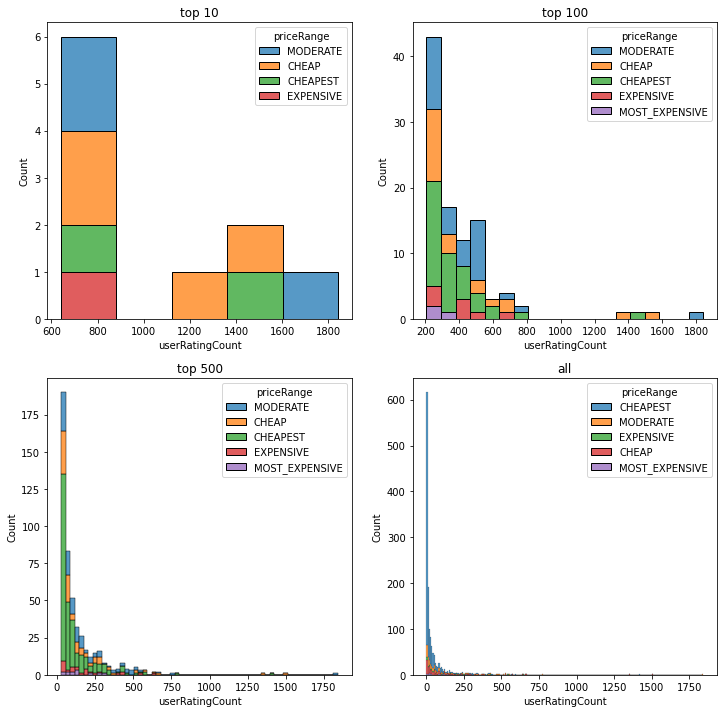

In [11]:
fig, axs = plt.subplots(nrows = 2, ncols=2, figsize=(12,12))
sns.histplot(tst.nlargest(10, 'userRatingCount'), x="userRatingCount", hue="priceRange", multiple="stack", ax=axs[0][0]).set_title('top 10')
sns.histplot(tst.nlargest(100, 'userRatingCount'), x="userRatingCount", hue="priceRange", multiple="stack", ax=axs[0][1]).set_title('top 100')
sns.histplot(tst.nlargest(500, 'userRatingCount'), x="userRatingCount", hue="priceRange", multiple="stack", ax=axs[1][0]).set_title('top 500')
sns.histplot(tst, x="userRatingCount", hue="priceRange", multiple="stack", ax=axs[1][1]).set_title('all')


